In [1]:
import sys

print(f"--- System Information ---")
print(f"Python Version: {sys.version}")
print("-" * 25)

print("\n--- Checking Library Versions ---")

try:
    import torch
    print(f"✅ PyTorch:       {torch.__version__}")
except ImportError:
    print("❌ PyTorch is not installed.")

try:
    import transformers
    print(f"✅ Transformers:  {transformers.__version__}")
except ImportError:
    print("❌ Transformers is not installed.")

try:
    import datasets
    print(f"✅ Datasets:      {datasets.__version__}")
except ImportError:
    print("❌ Datasets is not installed.")

try:
    import tokenizers
    print(f"✅ Tokenizers:    {tokenizers.__version__}")
except ImportError:
    print("❌ Tokenizers is not installed.")

try:
    import sacrebleu
    print(f"✅ Sacrebleu:     {sacrebleu.__version__}")
except ImportError:
    print("❌ Sacrebleu is not installed.")

try:
    import numpy
    print(f"✅ NumPy:         {numpy.__version__}")
except ImportError:
    print("❌ NumPy is not installed.")
    
try:
    import PIL
    print(f"✅ Pillow (PIL):  {PIL.__version__}")
except ImportError:
    print("❌ Pillow is not installed.")

--- System Information ---
Python Version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
-------------------------

--- Checking Library Versions ---
✅ PyTorch:       2.8.0+cu126
✅ Transformers:  4.41.2
✅ Datasets:      2.19.1
✅ Tokenizers:    0.19.1
✅ Sacrebleu:     2.4.2
✅ NumPy:         2.2.6
✅ Pillow (PIL):  11.1.0


In [2]:
import torch
import torch.nn as nn
import math
import os
import gzip
from datasets import Dataset, DatasetDict, Image as HFImage
from tokenizers import Tokenizer
from tqdm import tqdm
import sacrebleu

# --- 1. Setup and Constants ---
print("--- Setting up environment and constants ---")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters for both models
SRC_VOCAB_SIZE, TGT_VOCAB_SIZE = 10000, 10000
EMB_SIZE, NHEAD, FFN_HID_DIM = 256, 8, 512
NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS = 3, 3
CLIP_FEATURE_DIM = 512

# Special token indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
print(f"Using device: {DEVICE}")

# --- 2. Re-create the Dataset Object for Evaluation ---
print("\n--- Re-creating the mapped dataset from local files ---")
image_folder_path = os.path.join("flickr30k", "Images")
repo_path = "dataset"
final_dataset = None

if not (os.path.isdir(image_folder_path) and os.path.isdir(repo_path)):
    print(f"❌ ERROR: Required folders '{image_folder_path}' or '{repo_path}' not found.")
else:
    # This logic is from your 2.ipynb to build the correctly mapped dataset
    dataset_dict = {}
    split_map = {
        "train": {"en": "train.en.gz", "de": "train.de.gz", "files": "train.txt"},
        "validation": {"en": "val.en.gz", "de": "val.de.gz", "files": "val.txt"},
        "test": {"en": "test_2016_flickr.en.gz", "de": "test_2016_flickr.de.gz", "files": "test_2016_flickr.txt"}
    }
    text_path = os.path.join(repo_path, "data", "task1", "raw")
    files_path = os.path.join(repo_path, "data", "task1", "image_splits")

    for split_name, paths in split_map.items():
        with gzip.open(os.path.join(text_path, paths['en']), 'rt', encoding='utf-8') as f: en_sents = f.read().strip().split('\n')
        with gzip.open(os.path.join(text_path, paths['de']), 'rt', encoding='utf-8') as f: de_sents = f.read().strip().split('\n')
        with open(os.path.join(files_path, paths['files']), 'r', encoding='utf-8') as f: img_files = f.read().strip().split('\n')
        data = {'image': [os.path.join(image_folder_path, fname) for fname in img_files], 'en': en_sents, 'de': de_sents}
        dataset_dict[split_name] = Dataset.from_dict(data).cast_column("image", HFImage())
    
    final_dataset = DatasetDict(dataset_dict)
    print("✅ Dataset object created successfully.")

# --- 3. Load Shared Resources ---
print("\n--- Loading tokenizers and preparing test data ---")
tokenizer_en = Tokenizer.from_file("tokenizer_en.json")
tokenizer_de = Tokenizer.from_file("tokenizer_de.json")

test_data = final_dataset['test']
source_sentences = [example['en'] for example in test_data]
reference_translations = [example['de'] for example in test_data]

print(f"✅ Successfully loaded {len(source_sentences)} test sentences.")
print("Setup is complete.")

--- Setting up environment and constants ---
Using device: cuda

--- Re-creating the mapped dataset from local files ---
✅ Dataset object created successfully.

--- Loading tokenizers and preparing test data ---
✅ Successfully loaded 1000 test sentences.
Setup is complete.


In [3]:
# --- Cell 2: Model Architectures ---

# Helper classes used by both models
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# --- Model 1: Text-Only Transformer (from 1A.ipynb) ---
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int, emb_size: int, nhead: int,
                 src_vocab_size: int, tgt_vocab_size: int, dim_feedforward: int, dropout: float = 0.1):
        super().__init__()
        self.transformer = nn.Transformer(d_model=emb_size, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src, trg, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask)

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask)

# --- Model 2: Multi-Modal Transformer (from 2.ipynb) ---
class MultiModalTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int, emb_size: int, nhead: int,
                 src_vocab_size: int, tgt_vocab_size: int, dim_feedforward: int, dropout: float = 0.1,
                 clip_feature_dim: int = 512):
        super().__init__()
        self.transformer = nn.Transformer(d_model=emb_size, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        self.clip_projection = nn.Linear(clip_feature_dim, emb_size)

    def encode(self, src, src_mask, image_features):
        src_text_emb = self.positional_encoding(self.src_tok_emb(src))
        projected_img_emb = self.clip_projection(image_features).unsqueeze(0)
        encoder_input = torch.cat([projected_img_emb, src_text_emb], dim=0)
        return self.transformer.encoder(encoder_input, src_mask)

    def decode(self, tgt, memory, tgt_mask):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        return self.transformer.decoder(tgt_emb, memory, tgt_mask)

print("✅ Model architectures defined successfully.")

✅ Model architectures defined successfully.


In [4]:
# --- Cell 3: Evaluate Text-Only Model (Baseline) ---

# Helper function for the decoder's mask
def generate_square_subsequent_mask(sz, device):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# --- 1. Load the Text-Only Model ---
print("--- Evaluating Model 1: Text-Only Baseline ---")
text_only_model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                     NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
text_only_model.load_state_dict(torch.load('best_model.pth'))
text_only_model = text_only_model.to(DEVICE)
text_only_model.eval()
print("Text-only model loaded successfully.")

# --- 2. Define the Text-Only Translation Function ---
def translate_sentence_text_only(model, src_sentence, device, max_len=50):
    model.eval()
    src_tokens = [SOS_IDX] + tokenizer_en.encode(src_sentence).ids + [EOS_IDX]
    src_tensor = torch.LongTensor(src_tokens).unsqueeze(1).to(device)
    src_len = src_tensor.shape[0]
    src_mask = torch.zeros((src_len, src_len), device=device).type(torch.bool)

    with torch.no_grad():
        memory = model.encode(src_tensor, src_mask)
    
    ys = torch.ones(1, 1).fill_(SOS_IDX).type(torch.long).to(device)
    for i in range(max_len - 1):
        with torch.no_grad():
            tgt_len = ys.shape[0]
            tgt_mask = generate_square_subsequent_mask(tgt_len, device)
            out = model.decode(ys, memory, tgt_mask)
            out = out.transpose(0, 1)
            prob = model.generator(out[:, -1])
            _, next_word = torch.max(prob, dim=1)
            next_word = next_word.item()

        ys = torch.cat([ys, torch.ones(1, 1).type_as(src_tensor.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    
    tgt_tokens = ys.flatten().tolist()
    # Decode the tokens, skipping the initial SOS token.
    return tokenizer_de.decode(tgt_tokens[1:])

# --- 3. Generate Translations ---
print("\nGenerating translations for the test set using the text-only model...")
text_only_translations = []
for sentence in tqdm(source_sentences, desc="Text-Only Translation"):
    translation = translate_sentence_text_only(text_only_model, sentence, DEVICE)
    text_only_translations.append(translation)
print("Translation generation complete.")

# --- 4. Calculate BLEU Score ---
bleu_text_only = sacrebleu.corpus_bleu(text_only_translations, [reference_translations])

print("\n--- Text-Only Model Result ---")
print(f"BLEU Score: {bleu_text_only.score:.2f}")
print("----------------------------")

--- Evaluating Model 1: Text-Only Baseline ---


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Text-only model loaded successfully.

Generating translations for the test set using the text-only model...


Text-Only Translation: 100%|██████████| 1000/1000 [00:59<00:00, 16.78it/s]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


Translation generation complete.

--- Text-Only Model Result ---
BLEU Score: 30.42
----------------------------


In [5]:
# --- Cell 4: Evaluate Multi-Modal Model and Compare Results ---

# --- 1. Load the Multi-Modal Model ---
print("--- Evaluating Model 2: Multi-Modal Model ---")
multimodal_model = MultiModalTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                         NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
multimodal_model.load_state_dict(torch.load('best_multimodal_model.pth'))
multimodal_model = multimodal_model.to(DEVICE)
multimodal_model.eval()
print("Multi-modal model loaded successfully.")

# --- 2. Define the Multi-Modal Translation Function ---
def translate_sentence_multimodal(model, src_sentence, image_feature, device, max_len=50):
    model.eval()
    src_tokens = [SOS_IDX] + tokenizer_en.encode(src_sentence).ids + [EOS_IDX]
    src_tensor = torch.LongTensor(src_tokens).unsqueeze(1).to(device)
    image_feature = image_feature.to(device) # Ensure image feature is on the correct device
    
    # Adjust source mask for the additional image "token"
    src_len = src_tensor.shape[0]
    src_mask = torch.zeros((src_len + 1, src_len + 1), device=device).type(torch.bool)

    with torch.no_grad():
        memory = model.encode(src_tensor, src_mask, image_feature)
    
    ys = torch.ones(1, 1).fill_(SOS_IDX).type(torch.long).to(device)
    for i in range(max_len - 1):
        with torch.no_grad():
            tgt_len = ys.shape[0]
            tgt_mask = generate_square_subsequent_mask(tgt_len, device)
            out = model.decode(ys, memory, tgt_mask)
            out = out.transpose(0, 1)
            prob = model.generator(out[:, -1])
            _, next_word = torch.max(prob, dim=1)
            next_word = next_word.item()

        ys = torch.cat([ys, torch.ones(1, 1).type_as(src_tensor.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    
    tgt_tokens = ys.flatten().tolist()
    return tokenizer_de.decode(tgt_tokens[1:])

# --- 3. Generate Translations ---
print("\nGenerating translations for the test set using the multi-modal model...")
multimodal_translations = []
test_features_dir = "clip_features/test"

for i, sentence in enumerate(tqdm(source_sentences, desc="Multi-Modal Translation")):
    # Load the corresponding image feature for this sentence
    feature_path = os.path.join(test_features_dir, f"{i}.pt")
    image_feature = torch.load(feature_path)
    
    translation = translate_sentence_multimodal(multimodal_model, sentence, image_feature, DEVICE)
    multimodal_translations.append(translation)
print("Translation generation complete.")

# --- 4. Calculate BLEU Score ---
bleu_multimodal = sacrebleu.corpus_bleu(multimodal_translations, [reference_translations])

# --- 5. Final Comparison ---
print("\n\n===========================================")
print("    Final Project Results 🏆      ")
print("===========================================")
print(f"  Pre-trained MarianMT (Baseline) :   36.25")
print(f"  Your Text-Only Model (Baseline)   :   {bleu_text_only.score:.2f}")
print(f"  Your Multi-Modal Model          :   {bleu_multimodal.score:.2f}")
print("===========================================")

--- Evaluating Model 2: Multi-Modal Model ---
Multi-modal model loaded successfully.

Generating translations for the test set using the multi-modal model...


Multi-Modal Translation: 100%|██████████| 1000/1000 [01:23<00:00, 11.93it/s]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


Translation generation complete.


    Final Project Results 🏆      
  Pre-trained MarianMT (Baseline) :   36.25
  Your Text-Only Model (Baseline)   :   30.42
  Your Multi-Modal Model          :   31.13


               Displaying Test Example #351             

SOURCE (English):
'Three children's legs are shown as they stand near a mess of silly string.'

REFERENCE (German):'Die Beine von drei Kindern, die neben einem Durcheinander verknoteter Fäden stehen.'

------------------- PREDICTIONS --------------------
TEXT-ONLY MODEL PREDICTION:
'Drei Kinder haben die Beine eines Autos s , während sie neben einem Trainer an der Hand steht .'

MULTI-MODAL MODEL PREDICTION:
'Drei Kinder stehen auf den Beinen neben einer Haufen von ' s Seiten .'


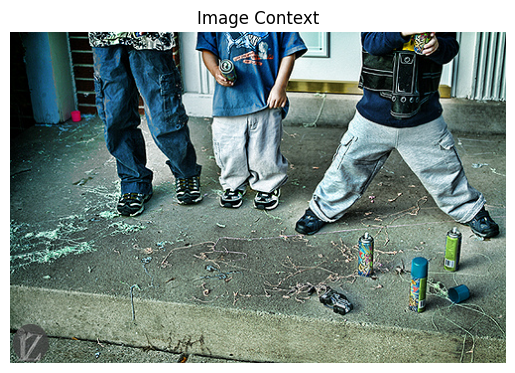

In [8]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# --- 1. Select a Random Example ---
# Pick a random index from the 1000 items in the test set
random_idx = random.randint(0, 999)

# Retrieve the data for this example
example = test_data[random_idx]
source_sentence = example['en']
reference_translation = example['de']
image_object = example['image']

# Load the corresponding pre-saved CLIP feature
feature_path = os.path.join("clip_features/test", f"{random_idx}.pt")
image_feature = torch.load(feature_path)

# --- 2. Generate Predictions from Both Models ---
text_only_prediction = translate_sentence_text_only(text_only_model, source_sentence, DEVICE)
multimodal_prediction = translate_sentence_multimodal(multimodal_model, source_sentence, image_feature, DEVICE)

# --- 3. Display the Results ---
print(f"               Displaying Test Example #{random_idx}             ")
print(f"\nSOURCE (English):\n'{source_sentence}'")
print(f"\nREFERENCE (German):'{reference_translation}'")
print("\n------------------- PREDICTIONS --------------------")
print(f"TEXT-ONLY MODEL PREDICTION:\n'{text_only_prediction}'")
print(f"\nMULTI-MODAL MODEL PREDICTION:\n'{multimodal_prediction}'")

# Display the image
plt.imshow(image_object)
plt.title("Image Context")
plt.axis('off')
plt.show()

In [9]:
import numpy
import pandas

print(numpy.__version__)
print(pandas.__version__)

2.2.6
2.3.3
